## Exercise 1: Anomaly Detection
*Implement the anomaly detection algorithm and apply it to detect failing servers on a network*

In [1]:
from numpy import *
%pylab inline
import scipy.optimize as op
import pandas as pd
import os
import scipy.io as sio
from sklearn import svm

Populating the interactive namespace from numpy and matplotlib


*Read data. Features measure the throughput (mb/s) and latency (ms) of response of each server. Use a Gaussian model to detect anomalous examples in your dataset.*

In [2]:
data = sio.loadmat("ex8data1.mat")
data.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [3]:
X = data["X"]
X.shape

(307L, 2L)

*Plot data. Clearly some data is very far from the norm.*

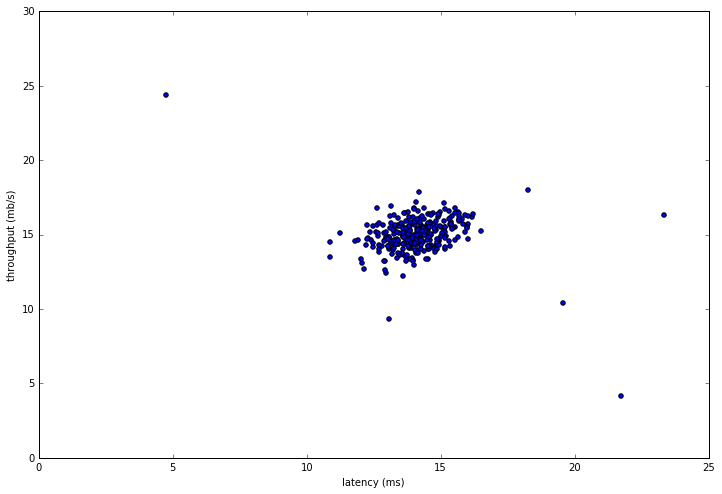

In [4]:
figure(figsize=(12,8))
scatter(X[:,0],X[:,1])
xlabel('latency (ms)')
ylabel('throughput (mb/s)')

*First step is to make a Gaussian fit to the data. Get mean (mu) and variance (sigma2).*

In [5]:
def estimateGaussian(X):
    b,n = X.shape
    mu = array(sum(X,0)/b)
    sigma2 = array(sum((X-mu)**2,0)/b)
    return (mu, sigma2)

In [6]:
mu, sigma2 = estimateGaussian(X)
mu, sigma2

(array([ 14.11222578,  14.99771051]), array([ 1.83263141,  1.70974533]))

*Or, we can use the built-in function to get the parameters.*

In [7]:
print(X.mean(axis=0))
print(X.var(axis=0))

[ 14.11222578  14.99771051]
[ 1.83263141  1.70974533]


In [8]:
n = shape(X)[1]
n

2L

*Write a function that returns the probability of a normal distribution for the given mu, sigma2 parameters.
X is a n-dimensional coordinate, as is mu. Sigma2 can be either a coordinate (list) or a nxn array.*

In [9]:
def Gaussian(X, mu, sigma2):
    # dimension of the Gaussian
    b,n = X.shape
    
    # if sigma2 is an array, treat as the covariance array 
    # if sigma2 is a vector, treat as the diagonal of the covariance array
    if size(sigma2.shape)==1:
        sigma2 = diag(sigma2)
               
    Xn = matrix(X-mu)
    sigma2 = matrix(sigma2)
    Sinv = inv(sigma2)
    
    D = zeros((1,b))
    
    for ii in range(b):
        D[0,ii] = Xn[ii,:]*Sinv*Xn[ii,:].T
    
    p = (2.0*pi)**(-n/2.0) * det(sigma2)**(-0.5) * exp(-0.5*D)
    
    return p

*Gaussian probability at each of the data points X. Plot data along with the Gaussian contours from the fit.*

In [10]:
p = Gaussian(X, mu, sigma2)

In [11]:
p.shape

(1L, 307L)

In [12]:
x1 = linspace(0,25,50)
x2 = linspace(0,30,50)
X1,X2 = meshgrid(x1,x2)

In [13]:
Xc = array([X1.flatten(),X2.flatten()]).T
Xc.shape

(2500L, 2L)

In [14]:
pc = Gaussian(Xc, mu, sigma2)
pc.reshape(50,50)

array([[  6.14537868e-54,   2.91057198e-52,   1.19597075e-50, ...,
          7.07255730e-42,   4.22371421e-43,   2.18839187e-44],
       [  1.18397177e-51,   5.60752273e-50,   2.30416330e-48, ...,
          1.36260247e-39,   8.13742920e-41,   4.21616687e-42],
       [  1.83197488e-49,   8.67659266e-48,   3.56526177e-46, ...,
          2.10837249e-37,   1.25911498e-38,   6.52372969e-40],
       ..., 
       [  1.76561917e-49,   8.36231902e-48,   3.43612492e-46, ...,
          2.03200542e-37,   1.21350875e-38,   6.28743459e-40],
       [  1.13921779e-51,   5.39555911e-50,   2.21706623e-48, ...,
          1.31109628e-39,   7.82983545e-41,   4.05679632e-42],
       [  5.90339647e-54,   2.79596446e-52,   1.14887786e-50, ...,
          6.79406624e-42,   4.05740002e-43,   2.10222112e-44]])

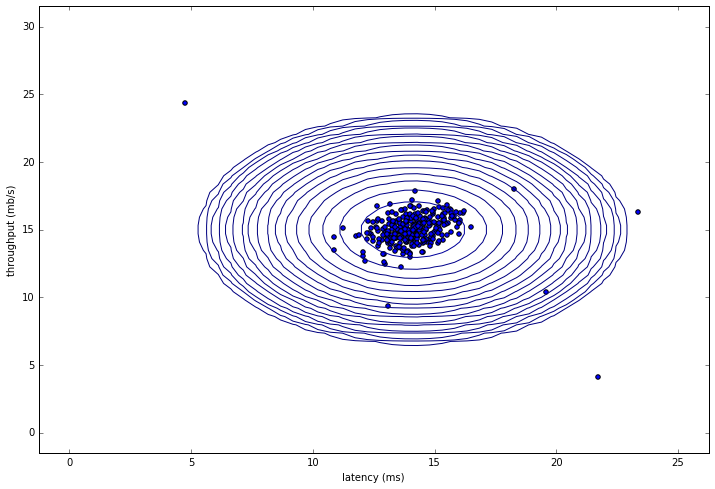

In [15]:
figure(figsize=(12,8))
scatter(X[:,0],X[:,1])
xlabel('latency (ms)')
ylabel('throughput (mb/s)')

levels = logspace(-10,0,20)

contour(X1,X2,pc.reshape(50,50),levels)

*Rather than write it myself, can also use built in stats to get the PDF*

In [16]:
from scipy import stats

In [17]:
S = diag(sigma2)
S

array([[ 1.83263141,  0.        ],
       [ 0.        ,  1.70974533]])

In [18]:
dist = stats.multivariate_normal(mean = mu, cov = S)

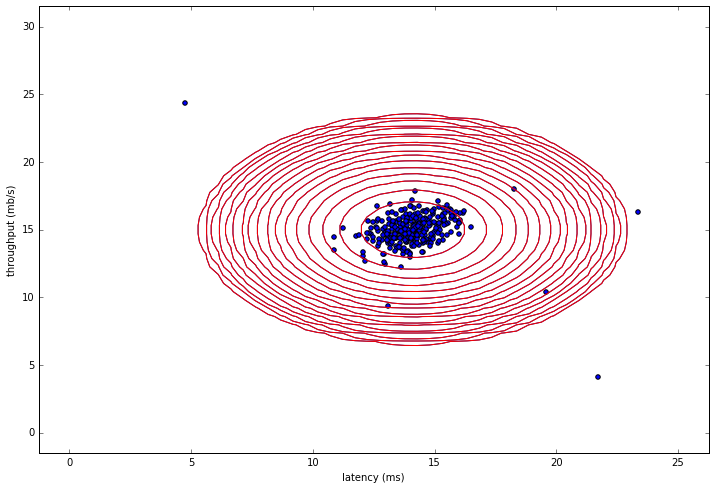

In [19]:
figure(figsize=(12,8))
scatter(X[:,0],X[:,1])
xlabel('latency (ms)')
ylabel('throughput (mb/s)')

levels = logspace(-10,0,20)

contour(X1,X2,pc.reshape(50,50),levels)
contour(X1,X2,dist.pdf(Xc).reshape(50,50),levels,colors = 'r',linestyle = '--')

In [20]:
p = dist.pdf(X)

*Plot a histogram of the probabilities at the measured data points. The anomalies are the points with very low probability.*

(array([   1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    0.,    2.,    6.,    7.,   23.,   74.,  188.]),
 array([-52.79291855, -52.28908428, -51.78525001, -51.28141575,
        -50.77758148, -50.27374721, -49.76991294, -49.26607868,
        -48.76224441, -48.25841014, -47.75457587, -47.25074161,
        -46.746907

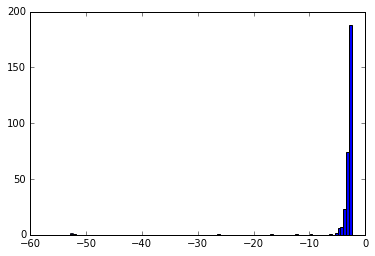

In [21]:
hist(log(p),100)

*Validation data*

In [22]:
Xval = data['Xval']
yval = data['yval']
pval = dist.pdf(Xval)

*Use validation data to choose the correct value of the probability threshold for detecting anomalies.*

In [23]:
def selectThreshold(yval, pval):
    
    best_epsilon = 0
    best_F = 0
    
    max_eps = pval.max()
    min_eps = pval.min()
    
    trials = 1000
    
    for epsilon in linspace(min_eps,max_eps,trials):
        # calculate F1 score
        y_negative = yval[pval>epsilon]
        y_positive = yval[pval<=epsilon]
        
        true_pos = float(sum(y_positive))
        false_neg = float(sum(y_negative))
        
        precision = true_pos/y_positive.size
        recall = true_pos/(true_pos+false_neg)
        
        F = (2.0*precision*recall)/(precision+recall)
        
        # store values for the best (highest) F score
        if (F>best_F):
            best_F = F
            best_epsilon = epsilon
    
    return best_epsilon, best_F


In [24]:
best_epsilon, best_F = selectThreshold(yval, pval)
best_epsilon, best_F

(8.999852631901394e-05, 0.8750000000000001)

*Plot the normal and anomalous data.*

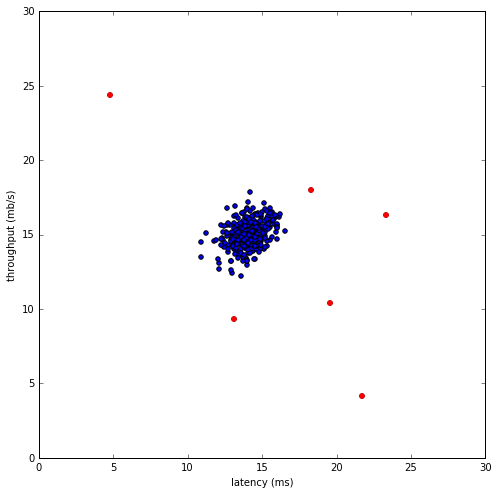

In [25]:
figure(figsize=(8,8))
scatter(X[:,0],X[:,1])
xlabel('latency (ms)')
ylabel('throughput (mb/s)')

xlim((0,30))
ylim((0,30))

anomalies = X[p<best_epsilon,:]
scatter(anomalies[:,0],anomalies[:,1],color = 'r', marker = 'o')

In [26]:
anomalies.shape

(6L, 2L)

*Now, repeat procedure with larger, multivariate data set.*

In [27]:
data = sio.loadmat('ex8data2.mat')
data.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [28]:
Xval = data['Xval']
yval = data['yval']
X = data['X']

X.shape, Xval.shape

((1000L, 11L), (100L, 11L))

In [29]:
# use full data set to estimate the Gaussian parameters
mu,sigma2 = estimateGaussian(X)
mu, sigma2

(array([  4.93940034,  -9.63726819,  13.81470749, -10.4644888 ,
         -7.95622922,  10.19950372,  -6.01940755,   7.96982896,
         -6.2531819 ,   2.32451289,   8.47372252]),
 array([ 60.97489373,  53.20572186,  58.51546272,  84.20403725,
         65.26859177,  89.57487757,  55.63349911,  87.16233783,
         29.62926829,  70.7852052 ,  50.50356719]))

In [30]:
S = diag(sigma2)
dist = stats.multivariate_normal(mean = mu, cov = S)

In [31]:
pval = dist.pdf(Xval)
p = dist.pdf(X)

In [32]:
best_epsilon, best_F = selectThreshold(yval, pval)
best_epsilon, best_F

(1.378607498200027e-18, 0.6153846153846154)

In [33]:
# now predict the anomalies in X
sum(p<best_epsilon)

117

*Try using the covariance matrix instead of just the diagonals*

In [34]:
S = np.cov(X.T)
dist = stats.multivariate_normal(mean = mu, cov = S)

In [35]:
pval = dist.pdf(Xval)
p = dist.pdf(X)

In [36]:
best_epsilon, best_F = selectThreshold(yval, pval)
best_epsilon, best_F

(1.7482478875565132e-18, 0.5517241379310345)

In [37]:
# now predict the anomalies in X
sum(p<best_epsilon)

122

For some reason, it gives a worse F value...

## Exercise 2: Recommender system
*Implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.*

In [38]:
data = sio.loadmat('ex8_movies.mat')
data.keys()

['Y', 'R', '__version__', '__header__', '__globals__']

In [39]:
ratings = data['Y']
rated = data['R']

In [40]:
movies, users = shape(ratings)
movies, users

(1682L, 943L)

In [41]:
print 'Toy story has an average rating of: %.2f' % mean(ratings[0,rated[0,:]])

Toy story has an average rating of: 4.52


*Visualize ratings across all movies*

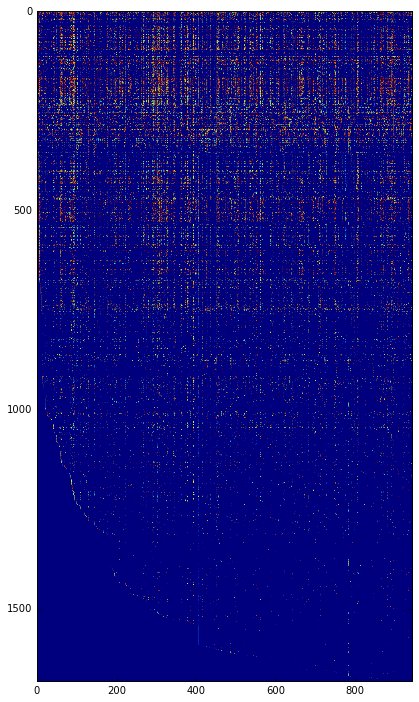

In [42]:
figure(figsize = (12,12))
imshow(ratings)

*Regularized collaborative filtering cost function and gradient*

In [43]:
def cofiCostFunc(params, ratings, rated, num_features, L):
    num_movies, num_users = ratings.shape
    ratings = matrix(ratings)
    rated = matrix(rated)
    
    # unroll the parameters
    movie_features = matrix(reshape(params[:num_movies*num_features],(num_movies,num_features)))
    user_preferences = matrix(reshape(params[num_movies*num_features:],(num_users,num_features)))
    
    # find error
    error = multiply(movie_features*user_preferences.T-ratings,rated)
    
    # compute the cost
    J = 0.5*sum(power(error,2))+L/2.*(sum(power(movie_features,2))+sum(power(user_preferences,2)))
    
    # compute the gradients of the parameter vectors movie_features and user_preferences
    grad_movie = error*user_preferences+L*movie_features
    grad_user = error.T*movie_features+L*user_preferences
    
    grad = concatenate((ravel(grad_movie), ravel(grad_user)))
    
    return J, grad

In [44]:
data = sio.loadmat('ex8_movieParams.mat')
data.keys()

['num_features',
 '__header__',
 '__globals__',
 'num_users',
 'X',
 'Theta',
 '__version__',
 'num_movies']

In [45]:
movie_features = data["X"]
user_preferences = data["Theta"]
num_features = data["num_features"]
num_users = data["num_users"]

In [46]:
movie_features.shape, user_preferences.shape

((1682L, 10L), (943L, 10L))

*Reduce size of data array for testing*

In [47]:
num_users = 4
num_movies = 5
num_features = 3

In [48]:
movie_features = movie_features[:num_movies, :num_features];
user_preferences = user_preferences[:num_users, :num_features];
ratings = ratings[:num_movies, :num_users];
rated = rated[:num_movies, :num_users];

In [49]:
movie_features.shape, user_preferences.shape, ratings.shape, rated.shape

((5L, 3L), (4L, 3L), (5L, 4L), (5L, 4L))

In [50]:
params = concatenate((ravel(movie_features), ravel(user_preferences)))
cofiCostFunc(params, ratings, rated, num_features,1.5)

(31.344056244274221,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

*Now add some ratings and run the normalization to find my own preferences*

In [51]:
data = sio.loadmat('ex8_movieParams.mat')
movie_features = data["X"]
user_preferences = data["Theta"]
num_features = data["num_features"]
num_users = data["num_users"]

In [52]:
movie_features.shape, user_preferences.shape

((1682L, 10L), (943L, 10L))

In [53]:
data = sio.loadmat('ex8_movies.mat')
ratings = data['Y']
rated = data['R']

ratings.shape

(1682L, 943L)

In [54]:
new_ratings = zeros((1682, 1))

new_ratings[0] = 4
new_ratings[6] = 3
new_ratings[11] = 5
new_ratings[53] = 4
new_ratings[63] = 5
new_ratings[65] = 3
new_ratings[68] = 5
new_ratings[97] = 2
new_ratings[182] = 4
new_ratings[225] = 5
new_ratings[354] = 5

# normalize
new_ratings = new_ratings

# add to data
ratings = hstack((ratings,new_ratings))

In [55]:
rated = hstack((rated,new_ratings>0))

In [56]:
rated.shape, ratings.shape
num_movies, num_users = rated.shape
(num_movies, num_users)

(1682L, 944L)

In [57]:
new_features = randn(num_movies, num_features)
new_preferences = randn(num_users, num_features)
initial_parameters = concatenate((ravel(new_features), ravel(new_preferences)))

C:\Users\Mya\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':
C:\Users\Mya\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app


*Normalize the ratings*

In [58]:
mean_ratings = sum(ratings,axis=1)/sum(rated,axis=1)
mean_ratings = reshape(mean_ratings, (num_movies,1))
norm_ratings = ratings-mean_ratings

In [59]:
new_features.shape, new_preferences.shape, num_users, num_features

((1682L, 10L), (944L, 10L), 944L, array([[10]], dtype=uint8))

In [60]:
fmin = op.minimize(fun=cofiCostFunc, x0=initial_parameters, args=(norm_ratings, rated, num_features, 10), 
                method='CG', jac=True, options={'maxiter': 100})

C:\Users\Mya\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
C:\Users\Mya\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [61]:
fmin

  status: 1
 success: False
    njev: 158
    nfev: 158
     fun: 38968.730287712526
       x: array([-0.43730383,  0.27060968, -0.2561767 , ...,  0.04895574,
        0.15746957, -0.03110993])
 message: 'Maximum number of iterations has been exceeded.'
     jac: array([ 0.12672755, -0.07173208, -0.04646134, ...,  0.01227031,
       -0.00380335, -0.00182705])
     nit: 100

*Now reshape the parameters, and solve for "my" preferences*

In [62]:
movie_features = matrix(reshape(fmin.x[:num_movies*num_features],(num_movies,num_features)))
user_preferences = matrix(reshape(fmin.x[num_movies*num_features:],(num_users,num_features)))

C:\Users\Mya\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':
C:\Users\Mya\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app


In [63]:
movie_features.shape, user_preferences.shape

((1682L, 10L), (944L, 10L))

In [64]:
p = dot(movie_features, user_preferences.T)
my_predictions = p[:,-1] + mean_ratings

In [65]:
p.max()

9.5334285605976294

In [66]:
# make movie list
movie_ids = []
f = open('movie_ids.txt')

# read each line
for i,line in enumerate(f):
    # split into words using whitespace as delimiter
    tokens = line.split(' ')
    info = ' '.join(tokens[1:])
    info = info.rstrip('\n')
    
    # then recombine all but the first element (the integer id)
    movie_ids.append(info)

movie_ids[0]

'Toy Story (1995)'

In [67]:
# sort my preference list and output my movie recommendations
sort_index = argsort(my_predictions,axis=0)[::-1]
sort_index[:10]

matrix([[1499],
        [1535],
        [1466],
        [ 813],
        [1121],
        [1652],
        [1200],
        [1598],
        [1292],
        [1188]], dtype=int64)

In [68]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(sort_index[i])
    print('Predicted rating of %.6f for movie %s.' % (my_predictions[j], movie_ids[j]))

Top 10 movie predictions:
Predicted rating of 5.000001 for movie Santa with Muscles (1996).
Predicted rating of 5.000000 for movie Aiqing wansui (1994).
Predicted rating of 5.000000 for movie Saint of Fort Washington, The (1993).
Predicted rating of 5.000000 for movie Great Day in Harlem, A (1994).
Predicted rating of 5.000000 for movie They Made Me a Criminal (1939).
Predicted rating of 5.000000 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 5.000000 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.000000 for movie Someone Else's America (1995).
Predicted rating of 5.000000 for movie Star Kid (1997).
Predicted rating of 5.000000 for movie Prefontaine (1997).


*Something is wrong with the ratings, probably having to do with the normalization.*